<a href="https://colab.research.google.com/github/toluwee/Machine_Learning_Projects/blob/master/CO2_EOR_PCA_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pa

## Objective

The goal of this research is to predict the level of enhanced oil recovery category a CO2 flooding will be based on several features. - Classification route to predict future field performance

The goal of this research is to determine the group to which each CO2 flooding project belong.

group similar CO2 flooding projects into the same cluster so that valuable operational design experiences and production performance from an analog case can be referenced for decision-making.

Besides, hidden patterns embedded in CO2 flooding applications can be revealed based on data characteristics of each cluster for different reservoir/fluid conditions. 

Methodology

Example Results

## About The Dataset



## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
%config InlineBackend.figure_format='retina'
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score

import plotly.express as px


In [2]:
# Load in the data
filepath = 'https://datasciencefiles.s3.us-east-2.amazonaws.com/CO2Flooding_data.csv'
df = pd.read_csv(filepath)


In [3]:
# fig = px.scatter_3d(data_frame=df, x="Por", y="Perm", z = 'Depth', color='Form', size='Depth', size_max=10 )
# fig.show()

In [4]:
fig = go.Figure(data=[go.Scatter3d(x=df["Por"], y=df["Perm"], z = df['Depth'],
    mode='markers',
    marker=dict(
        size=5,
        color=df['Depth'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Descriptive Statistics

In [5]:
from google.colab import data_table
data_table.DataTable(df)

,ID,Area,Prod_well,Inj_well,Form,Por,Perm,Depth,API,Visc,Temp,Prev_prod,Sat_start,Sat_end,Enh_prod
0,1,5800,79,40,S,20.00,30.0,5000,43.0,0.60,120,WF,39.0,24.0,3100.0
1,2,570,42,26,S,17.00,25.0,1750,39.0,0.60,105,Prim,32.0,24.0,NaN
2,3,1325,48,32,S,18.00,30.0,2200,39.0,0.60,112,Prim,32.0,24.0,NaN
3,4,3500,174,153,S,18.00,75.0,1900,37.0,0.60,105,WF,39.0,24.0,5000.0
4,5,6000,321,279,S,18.00,75.0,1900,37.0,0.60,105,WF,39.0,24.0,9500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,173,480,4,1,S,13.00,500.0,5075,42.0,1.14,133,WF,36.0,28.0,NaN
166,174,1280,5,2,S,13.00,500.0,5000,42.0,1.14,133,WF,38.0,28.0,NaN
167,177,2890,104,10,LS,1.06,1000.0,6700,18.0,22.00,237,Prim,NaN,NaN,587.0
168,178,200,5,1,Dolo,2.50,1000.0,7400,16.0,92.00,248,Prim,NaN,NaN,1053.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         170 non-null    int64  
 1   Area       170 non-null    int64  
 2   Prod_well  170 non-null    int64  
 3   Inj_well   170 non-null    int64  
 4   Form       170 non-null    object 
 5   Por        170 non-null    float64
 6   Perm       170 non-null    float64
 7   Depth      170 non-null    int64  
 8   API        170 non-null    float64
 9   Visc       170 non-null    float64
 10  Temp       170 non-null    int64  
 11  Prev_prod  170 non-null    object 
 12  Sat_start  140 non-null    float64
 13  Sat_end    102 non-null    float64
 14  Enh_prod   136 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 20.0+ KB


In [7]:
df.describe()

,ID,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Sat_end,Enh_prod
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,140.000000,102.000000,136.000000
mean,90.652941,3721.758824,75.105882,51.829412,14.896824,168.386471,6092.535294,37.156471,2.087176,136.747059,48.037857,29.723529,2222.531618
std,50.652344,6223.237019,135.282306,102.257826,6.593234,557.251835,2236.736386,4.865406,7.312254,46.123331,13.923767,10.607182,3844.643468
min,1.000000,5.000000,1.000000,1.000000,1.060000,1.500000,1150.000000,16.000000,0.000000,80.000000,17.000000,2.000000,0.000000
25%,48.250000,468.750000,8.250000,4.000000,10.000000,5.000000,4900.000000,34.000000,0.777500,104.000000,38.000000,24.000000,200.000000
50%,91.500000,1325.000000,29.000000,17.500000,13.000000,29.000000,5500.000000,38.000000,1.000000,112.500000,47.000000,29.000000,840.000000
75%,133.750000,4413.000000,78.500000,47.250000,18.075000,69.250000,6950.000000,41.000000,1.977500,152.000000,55.000000,37.000000,2750.000000
max,179.000000,49900.000000,1026.000000,816.000000,37.000000,4500.000000,11950.000000,48.000000,92.000000,260.000000,89.000000,52.000000,26530.000000


## Data Wrangling

### Handling missing data

In [8]:
#Missing data in Sat_start is filled with the average starting saturation in the data set. 

df.Sat_start = df.Sat_start.fillna(df.Sat_start.mean()) 


### Data type conversion 

In [9]:
"""
The 'Object' data types Form and Prev_prod are first converted to 
#category and then numeric codes for these categories are generated 
"""
df.Form = df.Form.astype('category')
df.Prev_prod = df.Prev_prod.astype('category')
df["Form_cat"] = df.Form.cat.codes
df["Prev_prod_cat"] = df.Prev_prod.astype('category').cat.codes

In [10]:
print(df.Form.cat.categories)
print(df.Form_cat.value_counts(sort= False))

Index(['Congl', 'Dolo', 'LS', 'S', 'Tripol'], dtype='object')
0     1
1    61
2    28
3    73
4     7
Name: Form_cat, dtype: int64


In [11]:
print(df.Prev_prod.cat.categories)
print(df.Prev_prod_cat.value_counts(sort= False))

Index(['GI', 'HC', 'None', 'Prim', 'WF'], dtype='object')
0      4
1      1
2      3
3     32
4    130
Name: Prev_prod_cat, dtype: int64


### Remove Redundant Columns and Null Values

In [12]:
#drop unused column
df_out = df.drop (columns=['ID','Sat_end','Form', 'Enh_prod','Prev_prod'])


In [13]:
#delete rows that have null values
df_out = df_out.dropna()
df_out.describe()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,3721.758824,75.105882,51.829412,14.896824,168.386471,6092.535294,37.156471,2.087176,136.747059,48.037857,2.141176,3.664706
std,6223.237019,135.282306,102.257826,6.593234,557.251835,2236.736386,4.865406,7.312254,46.123331,12.627599,0.980918,0.761065
min,5.000000,1.000000,1.000000,1.060000,1.500000,1150.000000,16.000000,0.000000,80.000000,17.000000,0.000000,0.000000
25%,468.750000,8.250000,4.000000,10.000000,5.000000,4900.000000,34.000000,0.777500,104.000000,39.250000,1.000000,4.000000
50%,1325.000000,29.000000,17.500000,13.000000,29.000000,5500.000000,38.000000,1.000000,112.500000,48.037857,2.000000,4.000000
75%,4413.000000,78.500000,47.250000,18.075000,69.250000,6950.000000,41.000000,1.977500,152.000000,52.000000,3.000000,4.000000
max,49900.000000,1026.000000,816.000000,37.000000,4500.000000,11950.000000,48.000000,92.000000,260.000000,89.000000,4.000000,4.000000


In [14]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           170 non-null    int64  
 1   Prod_well      170 non-null    int64  
 2   Inj_well       170 non-null    int64  
 3   Por            170 non-null    float64
 4   Perm           170 non-null    float64
 5   Depth          170 non-null    int64  
 6   API            170 non-null    float64
 7   Visc           170 non-null    float64
 8   Temp           170 non-null    int64  
 9   Sat_start      170 non-null    float64
 10  Form_cat       170 non-null    int8   
 11  Prev_prod_cat  170 non-null    int8   
dtypes: float64(5), int64(5), int8(2)
memory usage: 14.9 KB


### Handling outliers

In [15]:
Outlier_col = ['Visc', 'Perm', 'Area',	'Prod_well',	'Inj_well'] # columns identified in pairplot as having large outliers

for col in Outlier_col:
  val = df[col].quantile(0.75) * 1.5  # upper limit calculated by increasing 3rd quantile value by 50%
  df_out[col] = np.where(df_out[col] > val , val, df_out[col])   # replacing the outliers



The distribution shows that the influence of outliers have been reduced in the columns.

In [16]:
df_out.describe()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,2441.494118,44.344118,27.487500,14.896824,40.376176,6092.535294,37.156471,1.301022,136.747059,48.037857,2.141176,3.664706
std,2410.845870,42.341088,26.274171,6.593234,38.078145,2236.736386,4.865406,0.757088,46.123331,12.627599,0.980918,0.761065
min,5.000000,1.000000,1.000000,1.060000,1.500000,1150.000000,16.000000,0.000000,80.000000,17.000000,0.000000,0.000000
25%,468.750000,8.250000,4.000000,10.000000,5.000000,4900.000000,34.000000,0.777500,104.000000,39.250000,1.000000,4.000000
50%,1325.000000,29.000000,17.500000,13.000000,29.000000,5500.000000,38.000000,1.000000,112.500000,48.037857,2.000000,4.000000
75%,4413.000000,78.500000,47.250000,18.075000,69.250000,6950.000000,41.000000,1.977500,152.000000,52.000000,3.000000,4.000000
max,6619.500000,117.750000,70.875000,37.000000,103.875000,11950.000000,48.000000,2.966250,260.000000,89.000000,4.000000,4.000000


### Standardization

The decision to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, since it was measured on different scales. The data will be transformed onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.
The data is standardized using sklearn's StandardScaler.

In [17]:
X = df_out.values[:,0:]
X = np.nan_to_num(X)

In [18]:
# Standardize the data to have a mean of ~0 and a variance of 1
df_std = StandardScaler().fit_transform(X)

## Dataset Analysis

### Correlation

Visualisations is implemented to get a feel for how the correlations between the different features compare to one another. In the plots, the green, yellow and deep purple colors show how much correlated one feature is to another.

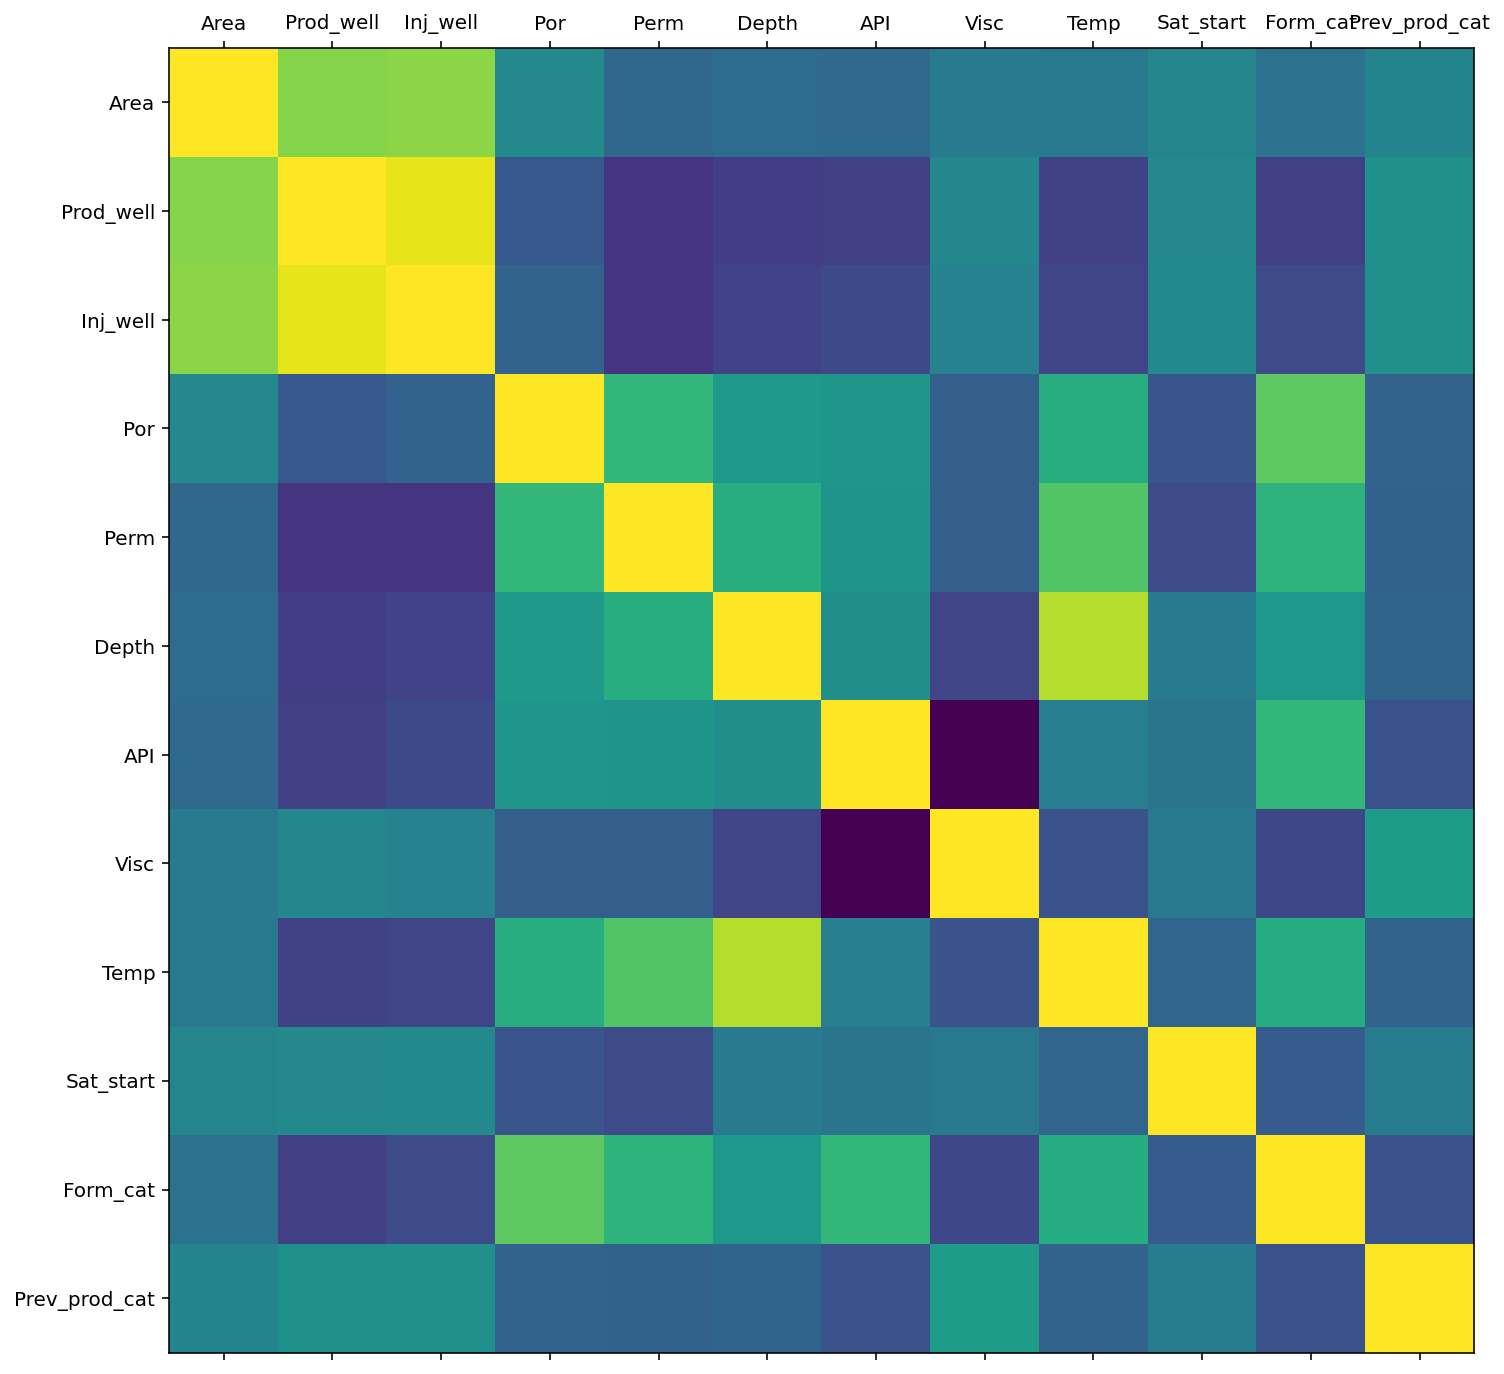

In [19]:
def plot_corr(df,size=12):
    corr = df_out.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);


plot_corr(df_out)


Figure 12.5 depicts the correlation between different columns. Since we are focusing on the
quality column, the quality column has a positive correlation with alcohol, sulfates, residual
sugar, citric acid, and fixed acidity. Since there are numbers, it is easy to see which columns
are positively correlated and which columns are negatively correlated.
Look at Figure 12.5 and see whether you can draw the following conclusions:
Alcohol is positively correlated with the quality of the red wine.
Alcohol has a weak positive correlation with the pH value.
Citric acid and density have a strong positive correlation with fixed acidity.
pH has a negative correlation with density, fixed acidity, citric acid, and sulfates. 

In [20]:
# sns.pairplot(df_out)

Prod_well and Inj_well are seen to be highly positively correlated to Area since the bigger the field, the higher the number of wells drillable. Also, Por is positively correlated to Perm while API has a high negative correlation to Visc. 
All these correlations are indicators that linearly correlated features can be found to perform PCA projections on.

### Feature Importance

In [21]:
#Identify numeric columns
df_num = df.drop(columns= ['ID','Form', 'Prev_prod']) 

In [22]:
df_features = df_num

df_features.dropna(inplace=True)


In [23]:
df_target = df_features.Enh_prod
df_features = df_features.drop(['Enh_prod'], axis =1)


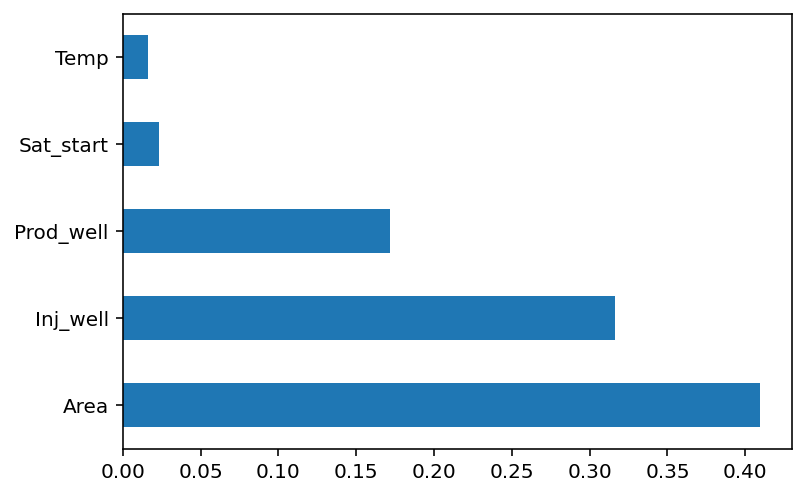

In [24]:
rfc = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
rfc.fit(df_features, df_target)
feat_importances = pd.Series(rfc.feature_importances_, index=df_features.columns)
feat_importances.nlargest().plot(kind='barh')


### Dataset visualization

The dataset will be visualized to see if any clusters with similarities can be observed just by eyeballing method

In [25]:
fig = px.scatter(data_frame=df_out,
                    x="Por",
                    y="Perm",
                    )

fig.show()


In [26]:

fig = px.scatter_3d(data_frame=df_out,
                    x= df_out.Por,
                    y= df_out.Perm,
                    z =df_out.Depth,
                    
                    )

fig.show()


No clearly identifiable cluster is observed

## KMeans 

Kmeans clustering is then implemented. First step is to determine the optimal number of clusters with the elbow method.

### Number of Clusters Determination

**Elbow Method**

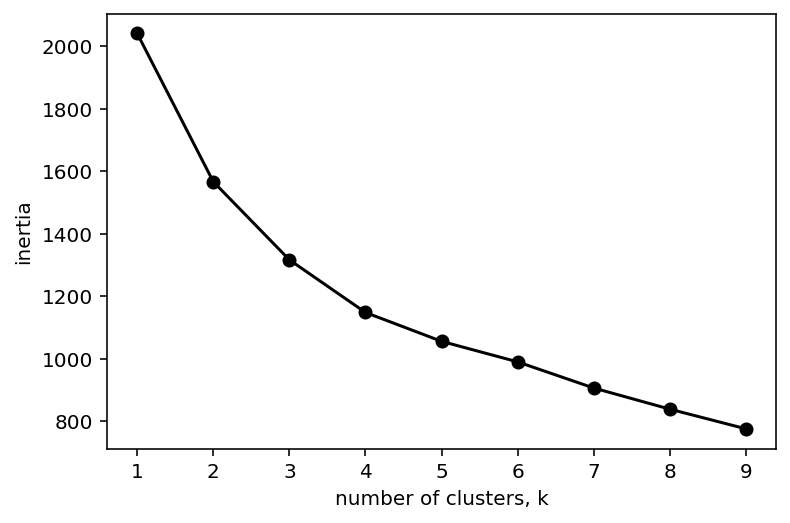

In [27]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init ='k-means++', max_iter=300, n_init=10,random_state=0)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**Silhouette Score Method**

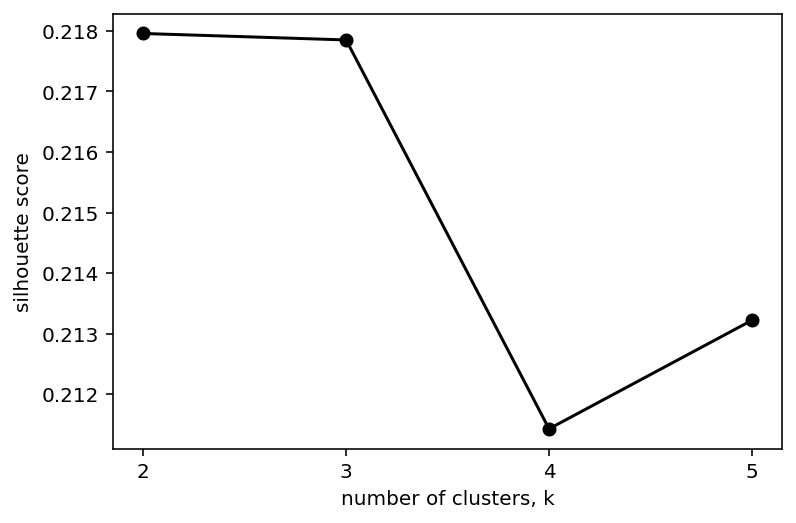

In [28]:
ks = range(2, 6)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init ='k-means++', max_iter=300, n_init=10,random_state=0)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

Figure shows that after 10 clusters at (the elbow) the change in the value of inertia is no longer significant and most likely, neither is the variance of the rest of the data after the elbow point. Therefore we can discard everything after k=10 and proceed to the last step in the process.

### KMeans Implementation

In [29]:
# Create a KMeans instance with k clusters: model
model = KMeans(n_clusters=2,  init ='k-means++', max_iter=300, n_init=10,random_state=0)
    
# Fit model to samples

y_kmeans = model.fit_predict(df_std)
labels = model.labels_

In [30]:
df_out["Cluster"] = labels
df_out.head(5)


,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat,Cluster
0,5800.0,79.00,40.000,20.0,30.0,5000,43.0,0.6,120,39.0,3,4,0
1,570.0,42.00,26.000,17.0,25.0,1750,39.0,0.6,105,32.0,3,3,0
2,1325.0,48.00,32.000,18.0,30.0,2200,39.0,0.6,112,32.0,3,3,0
3,3500.0,117.75,70.875,18.0,75.0,1900,37.0,0.6,105,39.0,3,4,1
4,6000.0,117.75,70.875,18.0,75.0,1900,37.0,0.6,105,39.0,3,4,1


In [31]:
df_out.groupby('Cluster').count()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
Cluster,,,,,,,,,,,,
0,95,95,95,95,95,95,95,95,95,95,95,95
1,75,75,75,75,75,75,75,75,75,75,75,75


In [32]:
df_out.groupby('Cluster').mean()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
Cluster,,,,,,,,,,,,
0,1724.652632,18.915789,12.936842,17.275789,59.215263,6819.684211,39.643158,1.052829,154.073684,45.092436,2.694737,3.463158
1,3349.493333,76.553333,45.918333,11.883467,16.513333,5171.480000,34.006667,1.615400,114.800000,51.768724,1.440000,3.920000


### Data visualization with Kmeans

In [33]:
df_out['Cluster No'] =df_out["Cluster"].map( {0: "first",
                                                 1:"second", 
                                                 })

In [34]:
# plt.figure(figsize=(12,7))
# sns.scatterplot(df_out.Por, 
#                 df_out.Perm,
#                 hue= df_out.Cluster,
#                 palette ='bright'
#                 )
# plt.xlabel('Porosity', fontsize=10)
# plt.ylabel('Permeability', fontsize=10)
# plt.show()


fig = px.scatter(data_frame=df_out,
                    x="Por",
                    y="Perm",
                    color='Cluster No',
                    color_discrete_sequence=px.colors.qualitative.Vivid
                    )

fig.show()


In [35]:
fig = px.scatter_3d(data_frame=df_out,
                    x= 'Por',
                    y= 'Perm',
                    z ='Depth',
                    color = 'Cluster No',
                    color_discrete_sequence=px.colors.qualitative.Vivid
                    
                    )

fig.show()

We proceed to implement PCA to attempt to get better definition of these clusters.

## Kmeans With PCA

### Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

Therefore, an eigendecomposition is performed using covariance matrix approach

In [36]:
cov_mat = np.cov(df_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-1.97775398e-01 -5.62696102e-01  1.84890572e-02  1.20770851e-02
  -4.69379825e-02  3.31220771e-02 -2.28464076e-02 -1.67242860e-01
  -1.61114452e-01 -6.26378816e-01  1.38391718e-01 -4.17752742e-01]
 [-3.84007753e-01 -3.98171183e-01  5.86954250e-02  8.64830005e-03
  -1.38725159e-01 -4.38829084e-02  7.19715528e-01  6.22252777e-02
  -4.57002352e-02  3.22702114e-01  1.36690227e-03  2.03022090e-01]
 [-3.65374327e-01 -4.28104274e-01  8.52333117e-02  1.64308369e-02
  -8.99099012e-02 -4.26042790e-02 -6.88808649e-01  7.12552311e-02
   3.14961189e-02  3.90643079e-01  2.25500212e-02  1.79325235e-01]
 [ 2.68604292e-01 -3.39098980e-01 -6.04899671e-02  3.68525247e-01
   2.26513954e-01  2.10968140e-01  3.53237506e-02  2.54060935e-02
   3.13819793e-01  1.05983907e-01 -6.58123206e-01 -1.81225696e-01]
 [ 3.47112802e-01 -1.65786588e-01 -2.36565039e-01  1.68241010e-01
  -3.25714924e-03 -3.71601529e-02 -4.23248761e-02 -1.45295415e-01
  -8.13312043e-01  9.52887741e-02 -1.17314690e-01  2.43200

In [37]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [38]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.891462367773725
2.1514023958692774
1.5043144382297853
1.222720851986308
0.9056167636485561
0.8033265481142856
0.4972063268963407
0.3730034843996219
0.3285860985039151
0.22515627570725613
0.1136312327133511
0.0545791333173506


In [39]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 32.23809511,  50.0609875 ,  62.52320025,  72.65260339,
        80.15501677,  86.81002592,  90.92903912,  94.019117  ,
        96.74122733,  98.60649256,  99.54784934, 100.        ])

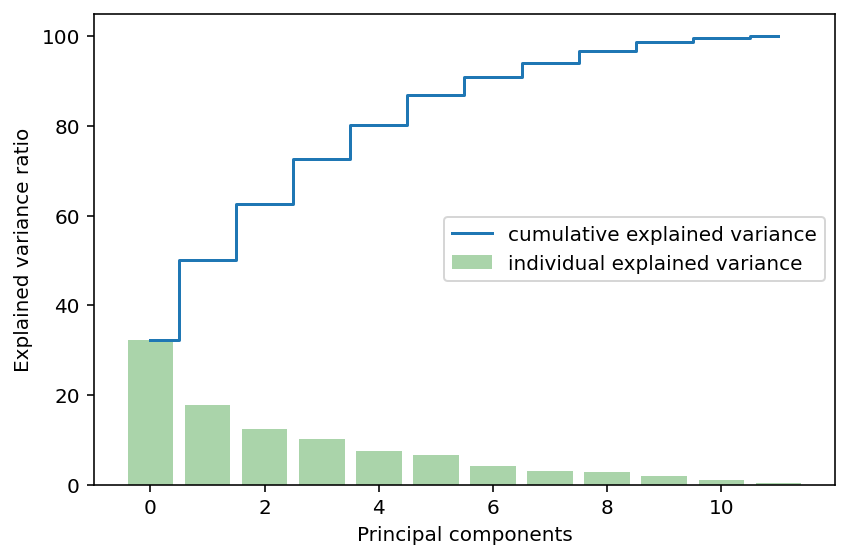

In [40]:
plt.style.context('seaborn-whitegrid')
plt.figure(figsize=(6, 4))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

Figure shows that the first 5 components explain the majority of the variance in our data. Following rule of thumb that at least 80% of the variance should be preserved, we select 5 features.


### PCA Implementation

Having roughly identified how many components/dimensions we would like to project on, let's now implement sklearn's PCA module.

The first line of the code contains the parameters "n_components" which states how many PCA components we want to project the dataset onto. Since we are going implement PCA with 5 components, therefore we set n_components = 5.

The second line of the code calls the "fit_transform" method, which fits the PCA model with the data df_std and applies the dimensionality reduction on this dataset.

In [41]:
# Create a PCA instance: pca
pca = PCA(n_components=5)
df_trans= pca.fit_transform(df_std)

print("original shape:   ", df_std.shape)
print("transformed shape:", df_trans.shape)

original shape:    (170, 12)
transformed shape: (170, 5)


### Projection Onto the New Feature Space

To illustrate the transformation of the data onto the new subspace, the plot of Oil gravity,API is transformed on the new subspace as shown in the figure below.


In [42]:
df_out['Enh_prod1'] = pd.qcut(df.Enh_prod, q= [0,0.25,0.75,1.0], labels=['Low','Medium','High'])# create bins from quantile 
y = df_out['Enh_prod1'].values

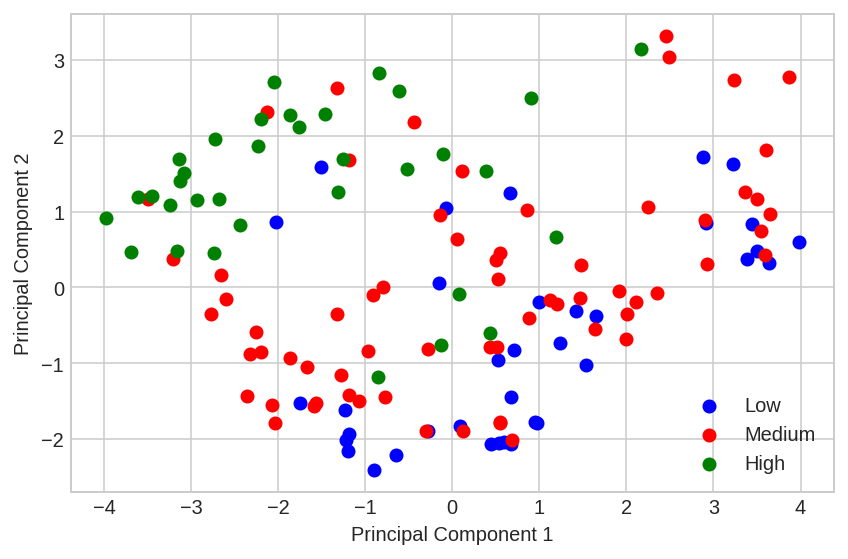

In [43]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Low', 'Medium', 'High'),
                        ('blue', 'red', 'green')):
        plt.scatter(df_trans[y==lab, 0],
                    df_trans[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

df_out = df_out.drop('Enh_prod1', axis=1)

After applying the linear PCA transformation, a lower dimensional subspace (from 13D to 5D in this case), is obtained where the samples are “most spread” along the new feature axes.

### KMeans on Principal Components Implementation

 

A simple KMeans will now be applied to the PCA projection data. 

Again the optimal number of clusters is determined.

### Number of Clusters Determination

**Elbow Method**

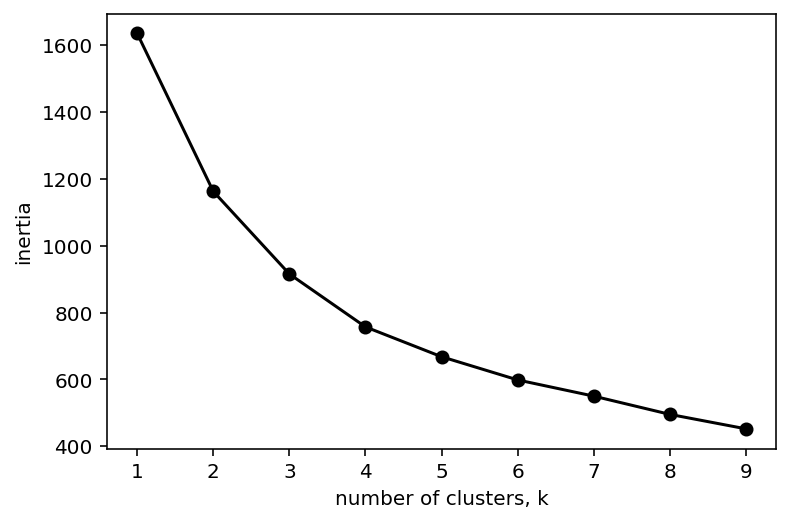

In [44]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init ='k-means++', max_iter=300, n_init=10,random_state=0)
    
    # Fit model to samples
    model.fit(df_trans)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**Silhouette Score Method**

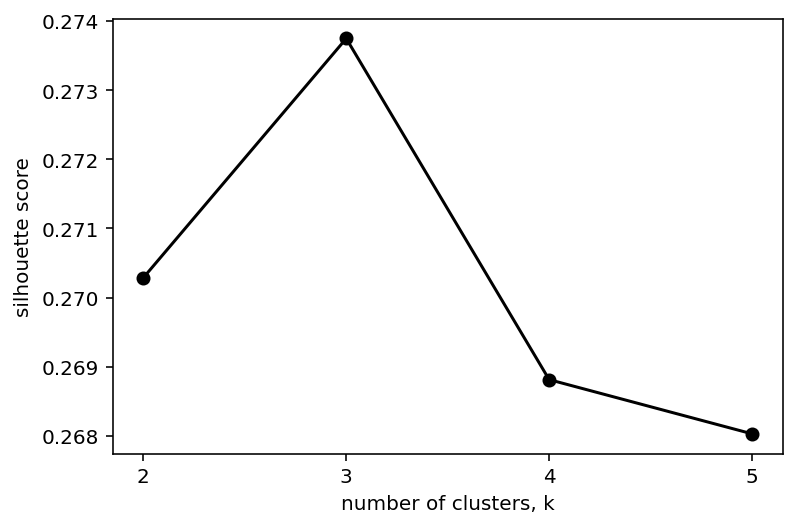

In [45]:
ks = range(2, 6)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init ='k-means++', max_iter=300, n_init=10,random_state=0)
    
    # Fit model to samples
    model.fit(df_trans)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_trans, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

Figure shows that after 11 clusters at (the elbow) the change in the value of inertia is no longer significant and most likely, neither is the variance of the rest of the data after the elbow point. Therefore we can discard everything after k=11 and proceed to the last step in the process.

The figure shows that 4 clusters should be ideal. 

### Kmeans Implementation

In [46]:
# Create a KMeans instance with k clusters: model
model1 = KMeans(n_clusters=3,  init ='k-means++', max_iter=300, n_init=10,random_state=0)
    
# Fit model to samples

y_kmeans1 = model1.fit_predict(df_trans)
labels1 = model1.labels_
centroids1 = model1.cluster_centers_

### Cluster Exploration

A new data frame will be created that facilitates adding in the values of the separate components to the data set. The scores of the components are stored and labelled as Component 1, 2, 3 and so on. 
In addition, the labels from the Kmeans clustering will be stored in the new data frame.

In [47]:
# Get original dataset
df_pca = df_out.drop(columns=['Cluster'], axis=1) 

# Create new dataframe with dataset and PCA components
df_clus = pd.concat([df_pca.reset_index(drop= True), pd.DataFrame(df_trans)], axis=1)

#Assign labels to components
df_clus.columns.values[-5:] = ['Principal Component 1', 'Principal Component 2',
                               'Principal Component 3','Principal Component 4',
                               'Principal Component 5'
                               ] 
df_clus["PCA_Cluster"] = labels1

df_clus.head()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat,Cluster No,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,PCA_Cluster
0,5800.0,79.00,40.000,20.0,30.0,5000,43.0,0.6,120,39.0,3,4,first,-0.110764,1.751431,-1.454924,-1.014231,-0.435066,0
1,570.0,42.00,26.000,17.0,25.0,1750,39.0,0.6,105,32.0,3,3,first,0.176883,-0.770925,-1.805861,-2.011151,0.435994,1
2,1325.0,48.00,32.000,18.0,30.0,2200,39.0,0.6,112,32.0,3,3,first,0.179364,-0.284579,-1.695117,-1.955985,0.519779,1
3,3500.0,117.75,70.875,18.0,75.0,1900,37.0,0.6,105,39.0,3,4,second,-1.257667,1.696869,-1.112355,-1.959857,-0.108295,0
4,6000.0,117.75,70.875,18.0,75.0,1900,37.0,0.6,105,39.0,3,4,second,-1.463362,2.282098,-1.131585,-1.972418,-0.059478,0


In [48]:
df_clus.groupby("PCA_Cluster").mean()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5
PCA_Cluster,,,,,,,,,,,,,,,,,
0,4751.215686,101.166667,61.664216,12.750196,20.606373,5351.352941,34.833333,1.535882,119.470588,52.222101,1.725490,3.941176,-2.122241,1.120705,0.019613,0.130585,0.097386
1,989.512987,21.506494,13.506494,12.928571,30.657792,5057.103896,38.209091,1.227159,112.727273,47.088071,2.064935,3.532468,0.117944,-1.161744,-0.505501,-0.195737,-0.135820
2,2298.797619,17.214286,11.619048,21.111905,82.199405,8890.833333,38.047619,1.151250,201.761905,44.698265,2.785714,3.571429,2.360777,0.769007,0.902936,0.200283,0.130749


In [49]:
df_clus.groupby("PCA_Cluster").count()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat,Cluster No,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5
PCA_Cluster,,,,,,,,,,,,,,,,,,
0,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
1,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
2,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42


## Data Visualization

### Scatterplot

We create a new column named ‘Cluster’ and map the clusters directly inside it.

In [50]:
df_clus['Cluster'] =df_clus["PCA_Cluster"].map( {0: "first",
                                                 1:"second", 
                                                 2: "third",
                                                })

In [51]:
fig = px.scatter(data_frame=df_clus,
                    x="Principal Component 1",
                    y="Principal Component 2",
                    color='Cluster',
                    color_discrete_sequence=px.colors.qualitative.Plotly
                    )

fig.show()



Looks like something that could be better defined with 3D!

In [52]:
fig = px.scatter_3d(data_frame=df_clus,
                    x="Principal Component 1",
                    y="Principal Component 2",
                    z = 'Principal Component 3',
                    color='Cluster',
                    color_discrete_sequence=px.colors.qualitative.Bold
                    )

fig.show()

Next the clusters are visualized relative to the field features to determine the reservoir, fluid, and field properties that are criteria for cluster membership.

In [53]:
df_clus.describe()

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,PCA_Cluster
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,170.000000
mean,2441.494118,44.344118,27.487500,14.896824,40.376176,6092.535294,37.156471,1.301022,136.747059,48.037857,2.141176,3.664706,-7.836868e-17,-3.004133e-17,4.963350e-17,1.306145e-18,-4.685794e-17,0.947059
std,2410.845870,42.341088,26.274171,6.593234,38.078145,2236.736386,4.865406,0.757088,46.123331,12.627599,0.980918,0.761065,1.972679e+00,1.466766e+00,1.226505e+00,1.105767e+00,9.516390e-01,0.739917
min,5.000000,1.000000,1.000000,1.060000,1.500000,1150.000000,16.000000,0.000000,80.000000,17.000000,0.000000,0.000000,-3.978535e+00,-2.401379e+00,-3.770702e+00,-2.949574e+00,-3.031168e+00,0.000000
25%,468.750000,8.250000,4.000000,10.000000,5.000000,4900.000000,34.000000,0.777500,104.000000,39.250000,1.000000,4.000000,-1.499114e+00,-1.146998e+00,-8.291821e-01,-7.096841e-01,-6.363074e-01,0.000000
50%,1325.000000,29.000000,17.500000,13.000000,29.000000,5500.000000,38.000000,1.000000,112.500000,48.037857,2.000000,4.000000,1.184126e-01,-1.374953e-01,1.059485e-01,1.190667e-01,8.686107e-02,1.000000
75%,4413.000000,78.500000,47.250000,18.075000,69.250000,6950.000000,41.000000,1.977500,152.000000,52.000000,3.000000,4.000000,1.377542e+00,1.157147e+00,6.859323e-01,6.317205e-01,4.686623e-01,1.000000
max,6619.500000,117.750000,70.875000,37.000000,103.875000,11950.000000,48.000000,2.966250,260.000000,89.000000,4.000000,4.000000,3.985373e+00,3.317023e+00,4.894286e+00,3.267913e+00,3.908787e+00,2.000000


### Boxplot 

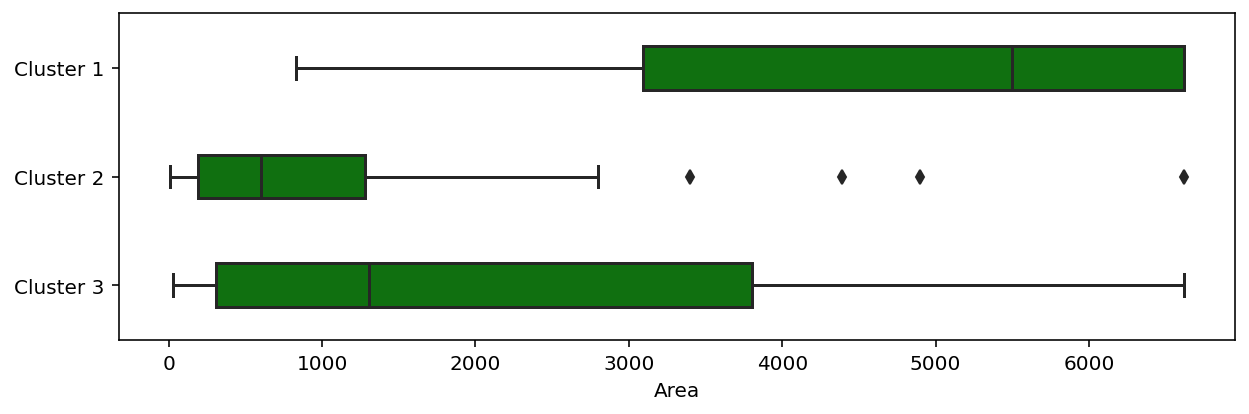

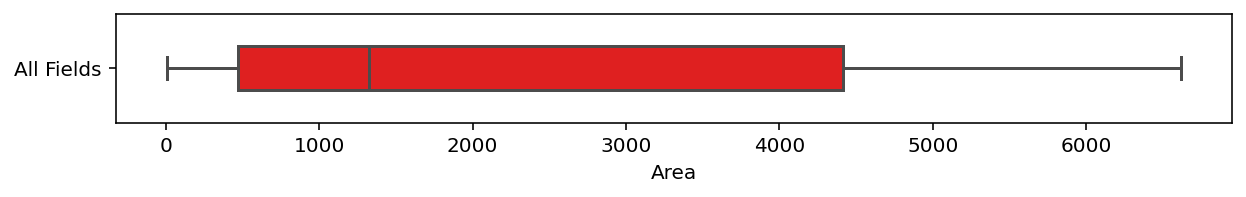

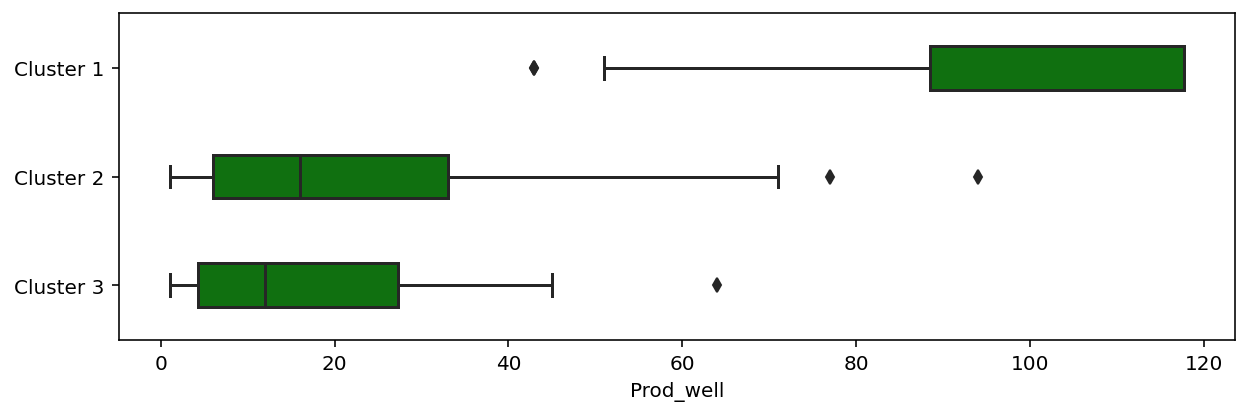

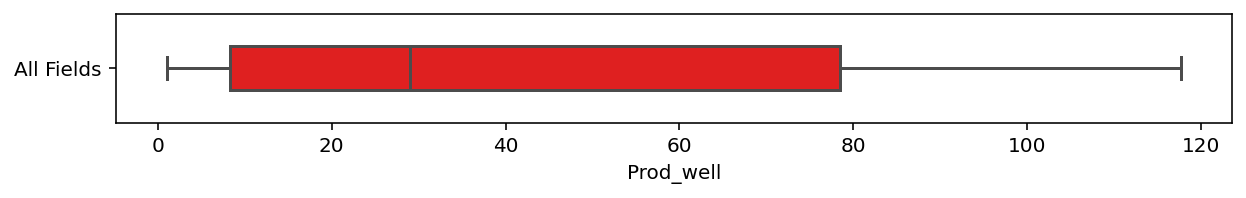

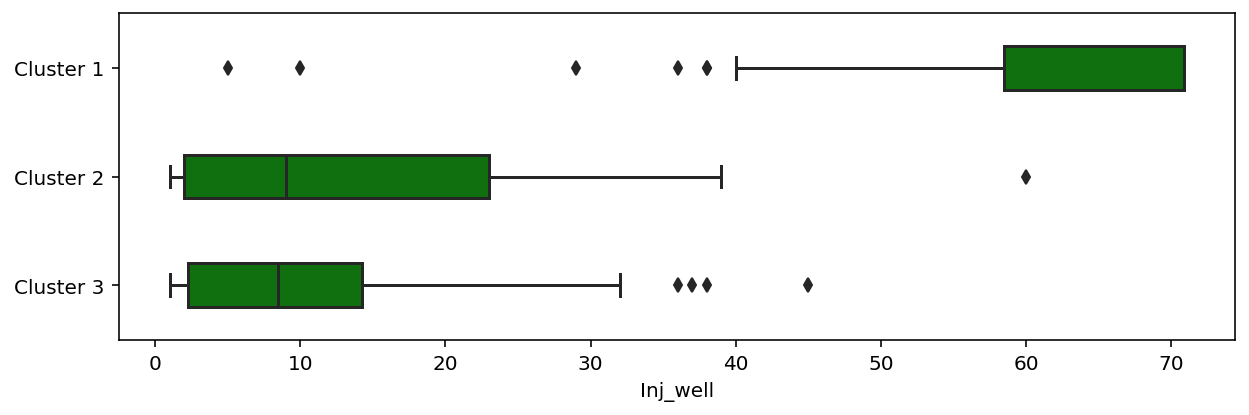

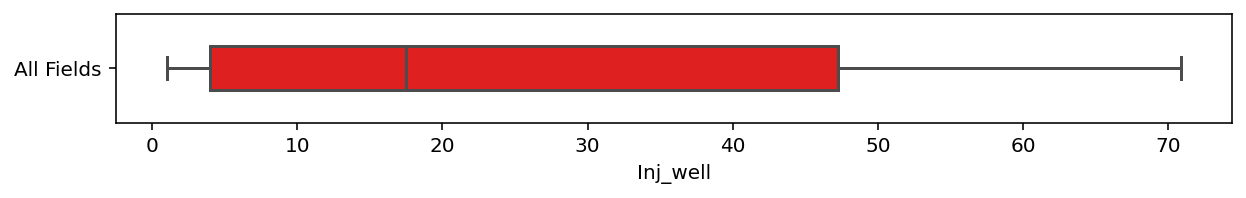

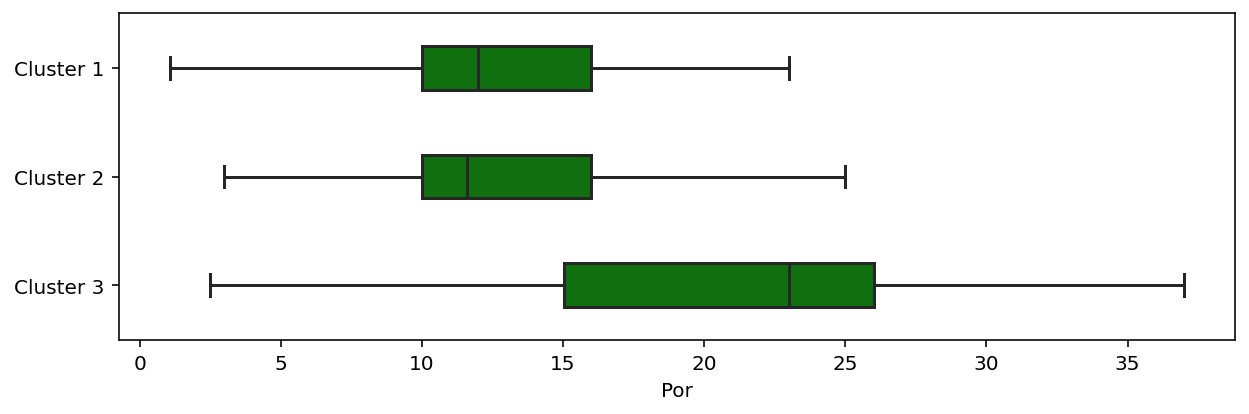

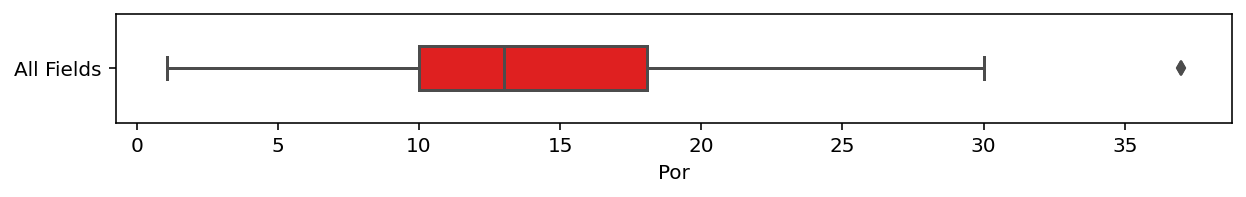

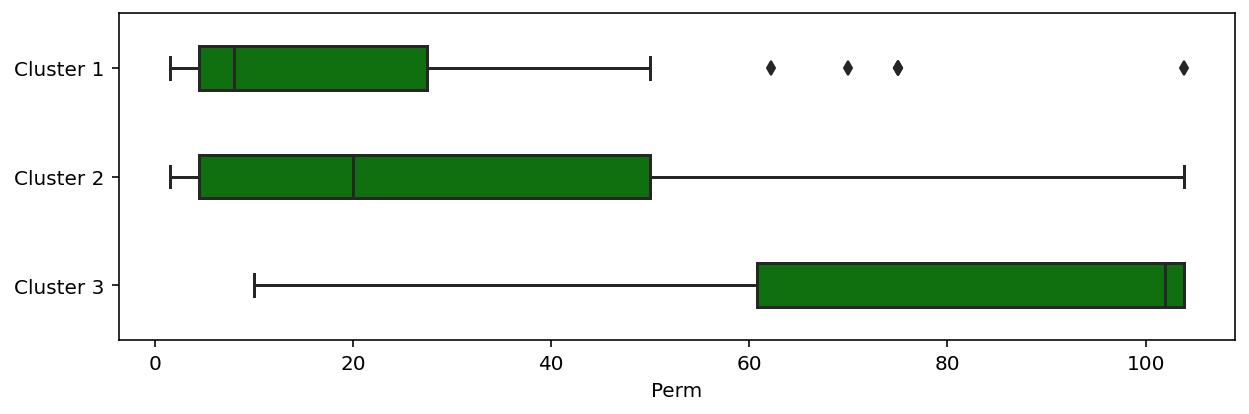

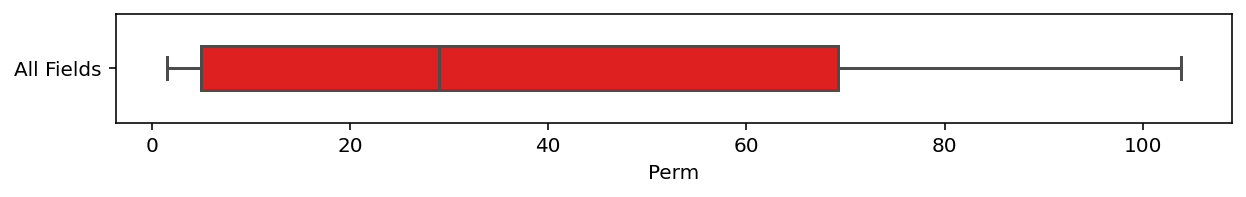

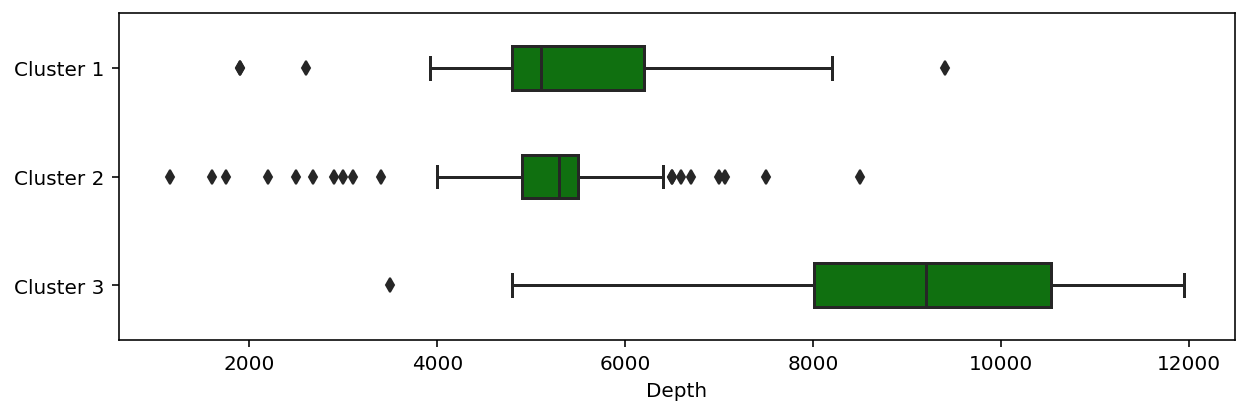

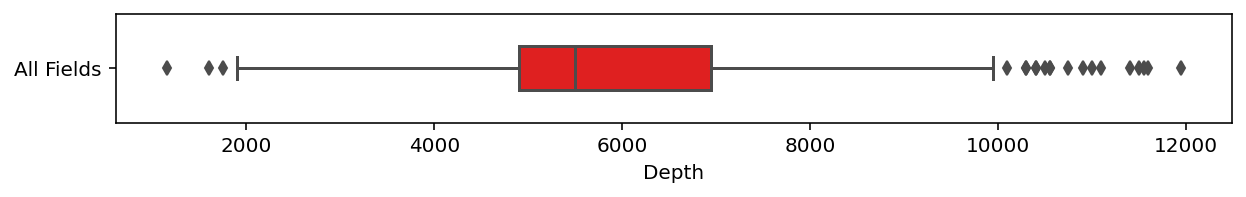

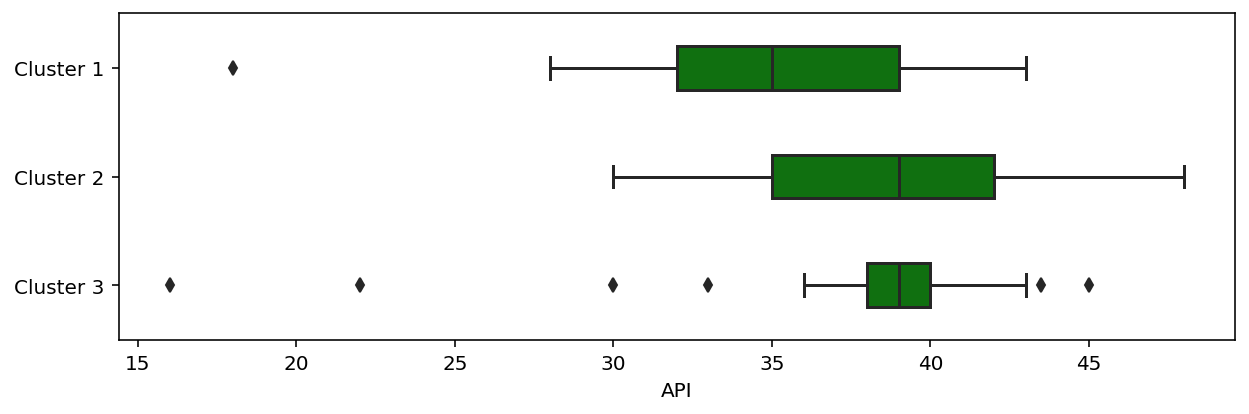

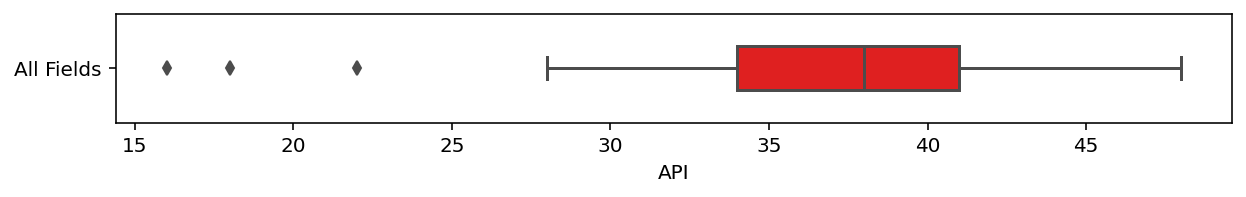

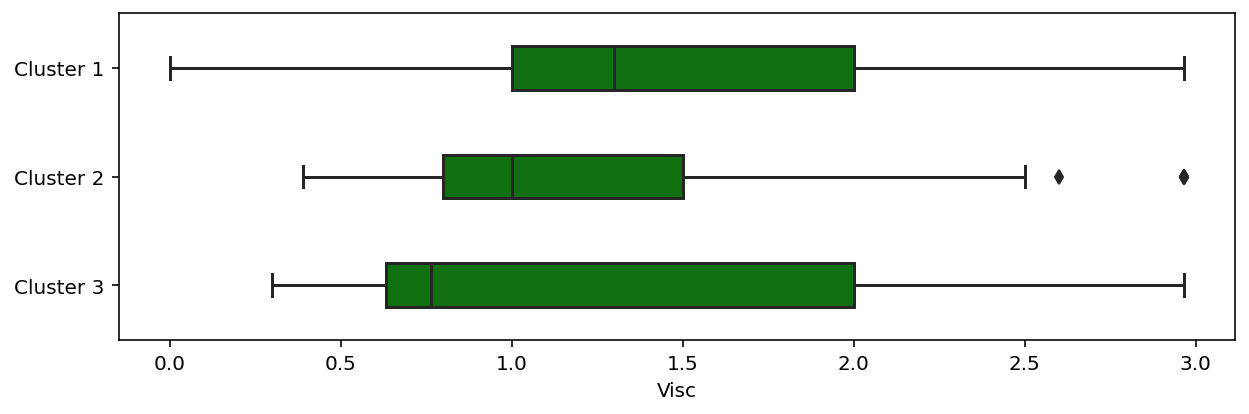

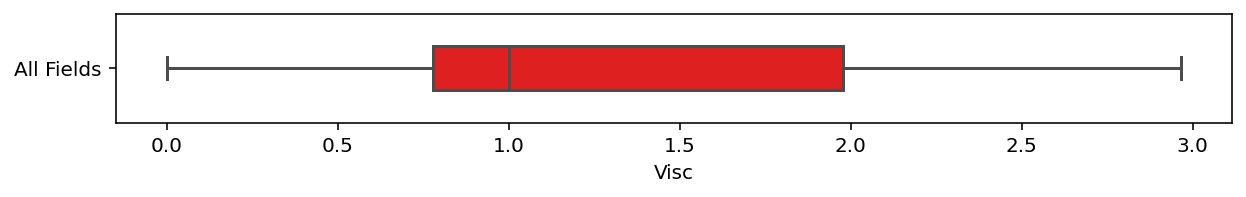

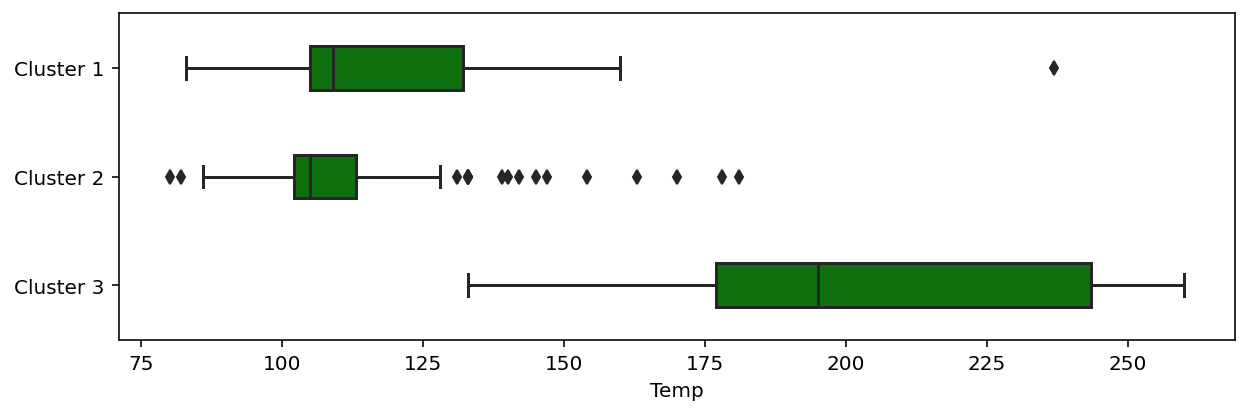

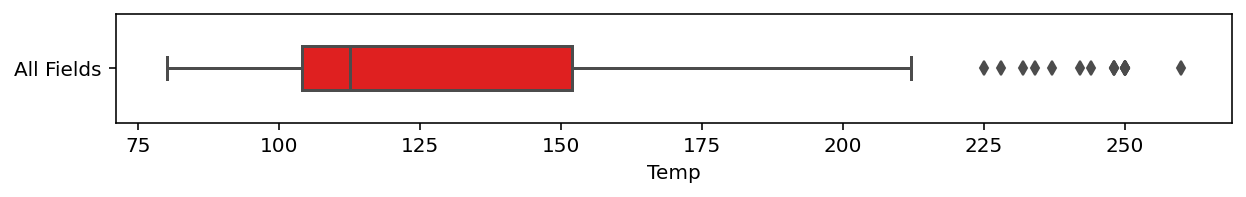

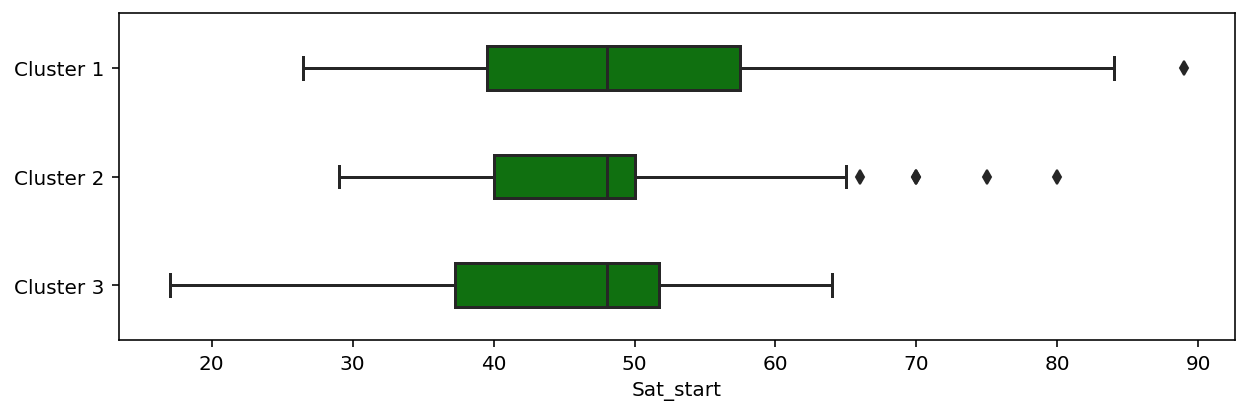

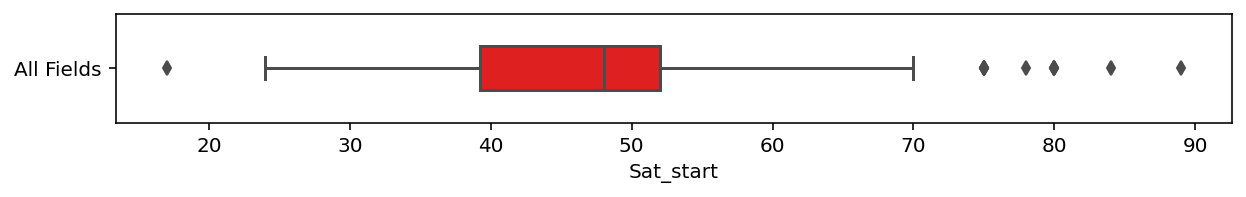

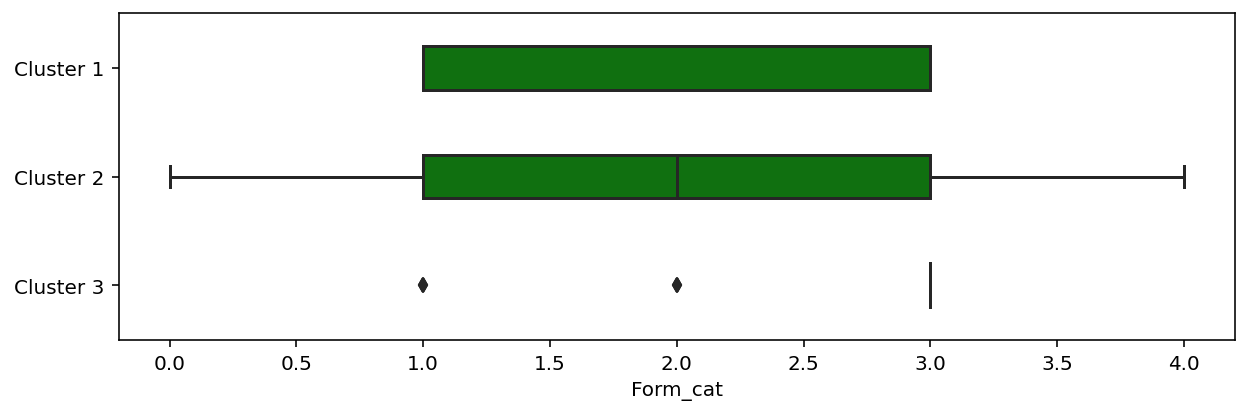

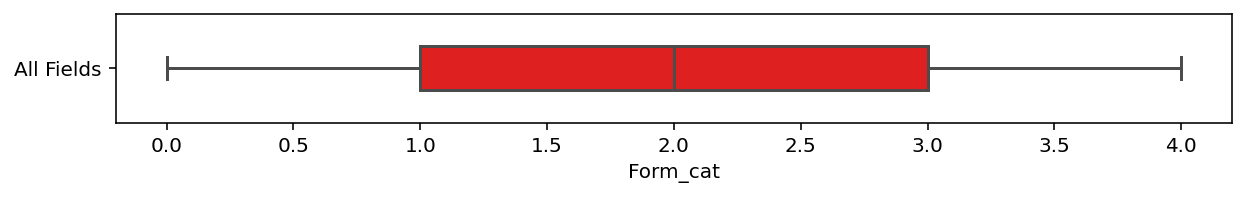

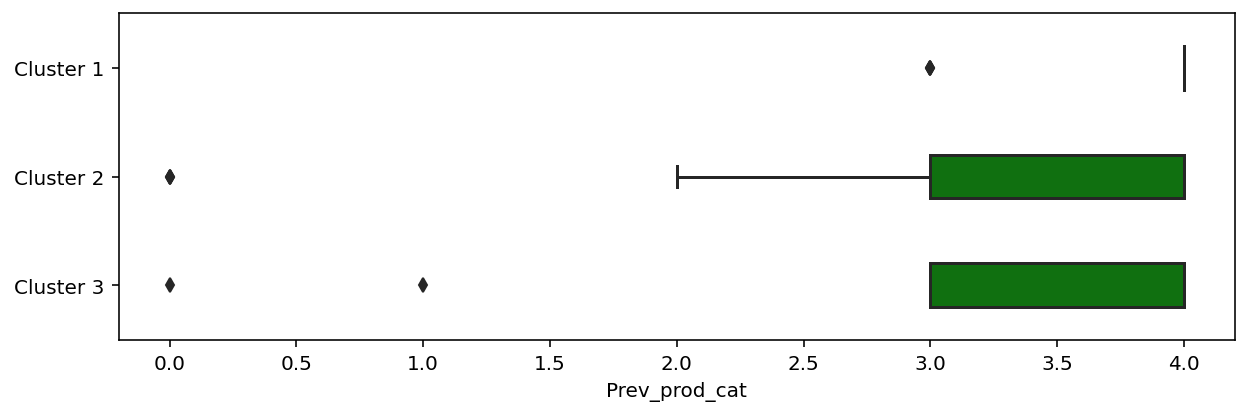

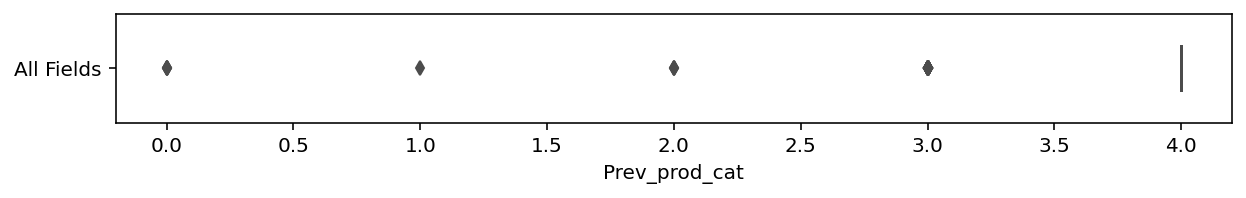

In [54]:
df_im = df_clus.drop(columns=['Principal Component 1',
                              'Principal Component 2','Principal Component 3',	
                              'Principal Component 4',	'Principal Component 5', 'Cluster No','Cluster'], axis=1)
column = df_im.drop('PCA_Cluster',axis=1).columns

for col in column:
  plt.figure(figsize=(10,3))
  sns.boxplot(x=df_im[col], y=df_im['PCA_Cluster'], color = 'green', width = 0.4, orient='h' )
  plt.yticks([0,1, 2], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
  plt.ylabel('')
  plt.show()
  
  plt.figure(figsize=(10,1))
  sns.boxplot(data=df_clus, x=col, width= 0.4, color= 'red', orient='h')
  plt.yticks([0], ['All Fields'])
  plt.show()


## Sub-categories of Properties

### Reservoir Properties

([<matplotlib.axis.YTick at 0x7f0ce43ebe10>,
 [])

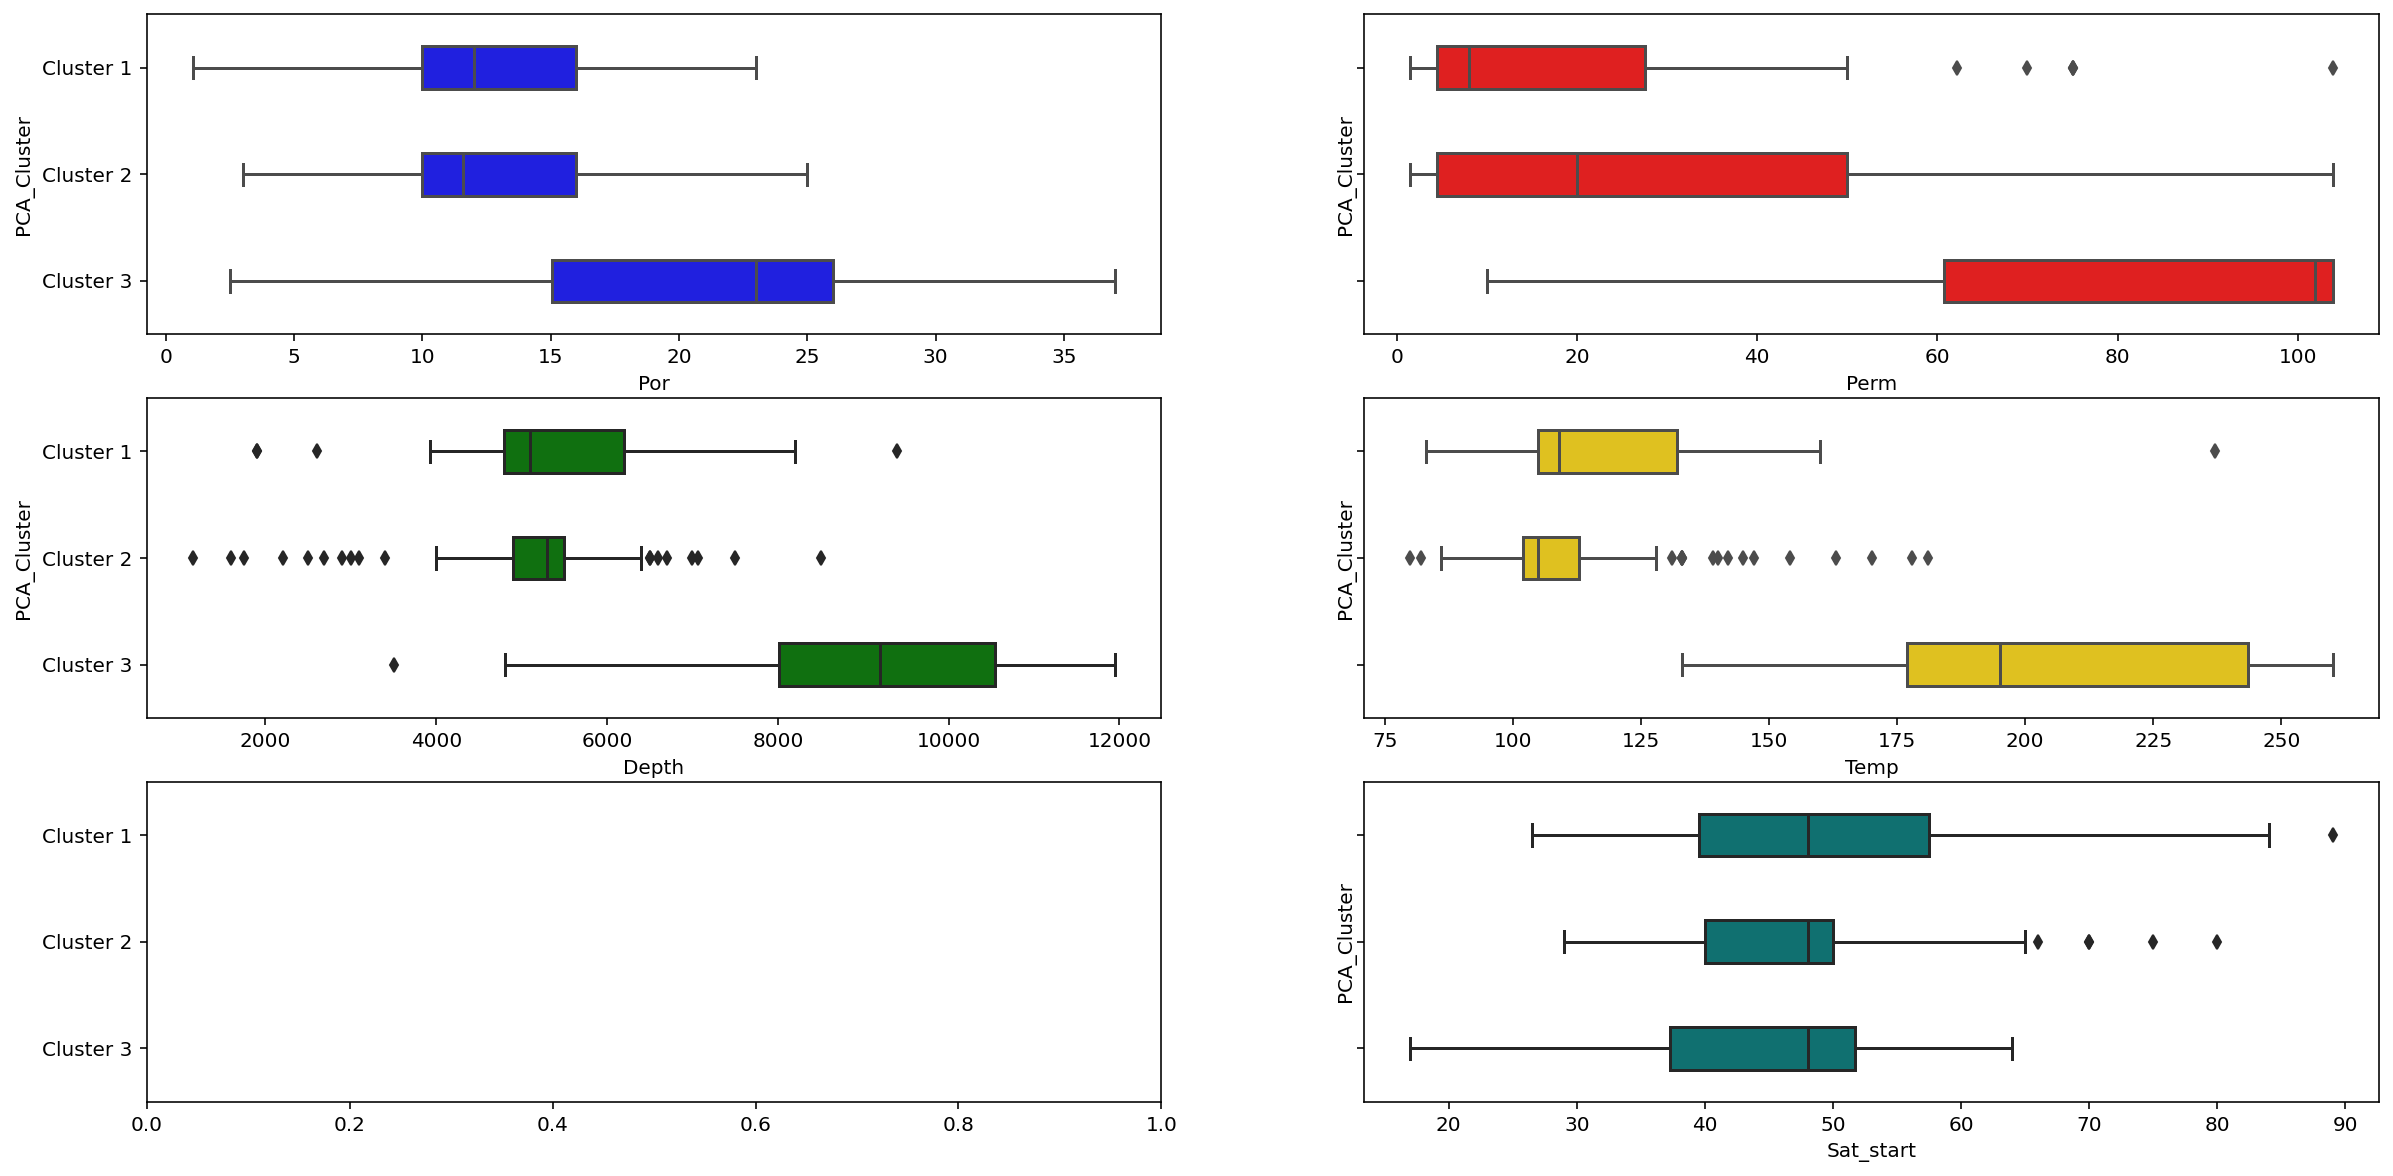

In [55]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10), sharey=True)
width = .4
sns.boxplot(y="PCA_Cluster", x='Por', color="blue", data= df_clus, ax=axes[0, 0], width=width,orient='h')
sns.boxplot(y="PCA_Cluster", x='Perm', color="red", data= df_clus, ax=axes[0, 1], width=width,orient='h')
sns.boxplot(y="PCA_Cluster", x='Depth', color="green", data= df_clus, ax=axes[1, 0], width=width,orient='h')
sns.boxplot(y="PCA_Cluster", x='Temp', color="gold", data= df_clus, ax=axes[1, 1], width=width,orient='h')
sns.boxplot(y="PCA_Cluster", x='Sat_start', color="teal", data= df_clus, ax=axes[2, 1], width=width,orient='h')
plt.yticks([0,1, 2], ['Cluster 1', 'Cluster 2', 'Cluster 3'])

### Fluid Properties

([<matplotlib.axis.YTick at 0x7f0ce43936a0>,
 [])

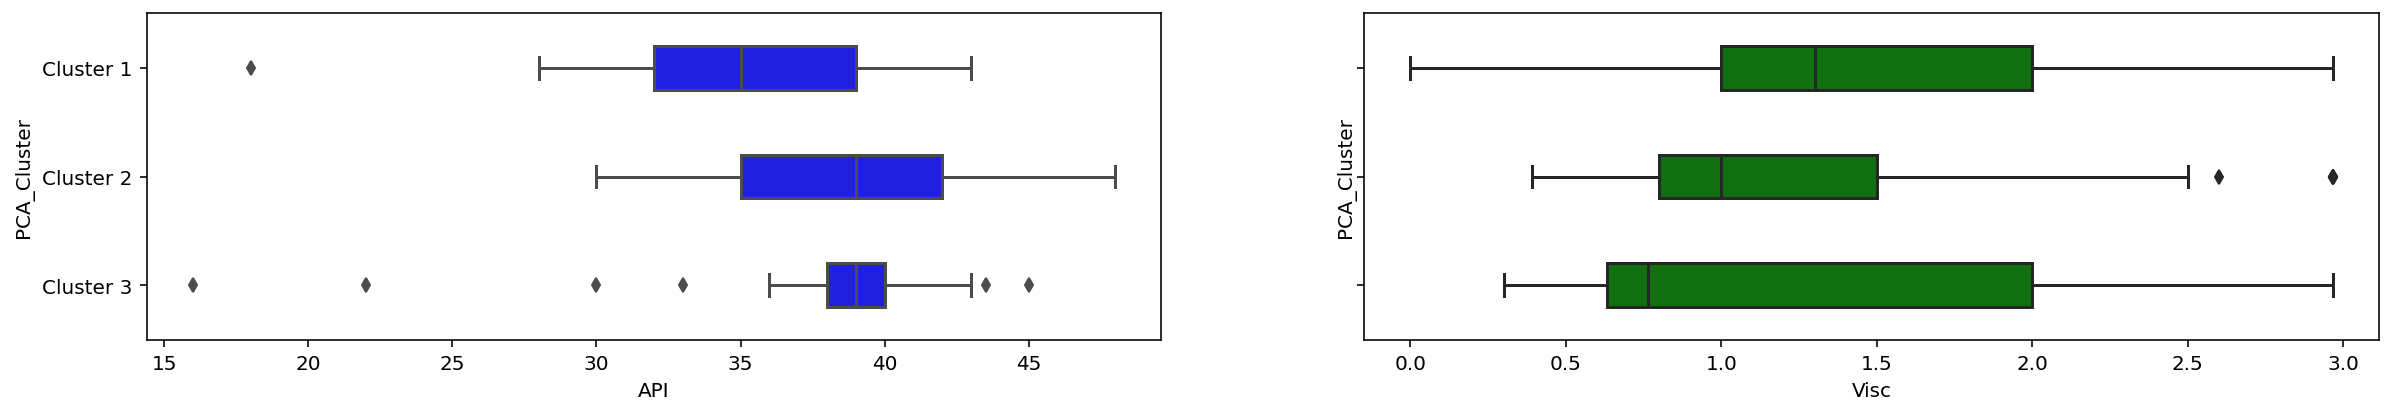

In [56]:
f, axes = plt.subplots(ncols=2, figsize=(20, 3), sharey=True)
width = .4
sns.boxplot(y="PCA_Cluster", x='API', color="blue", data= df_clus, ax=axes[0], orient='h', width=width)
sns.boxplot(y="PCA_Cluster", x='Visc', color="green", data= df_clus, ax=axes[1],orient='h', width=width)
plt.yticks([0,1, 2], ['Cluster 1', 'Cluster 2', 'Cluster 3'])

### Field Properties

([<matplotlib.axis.YTick at 0x7f0ce2b10518>,
 [])

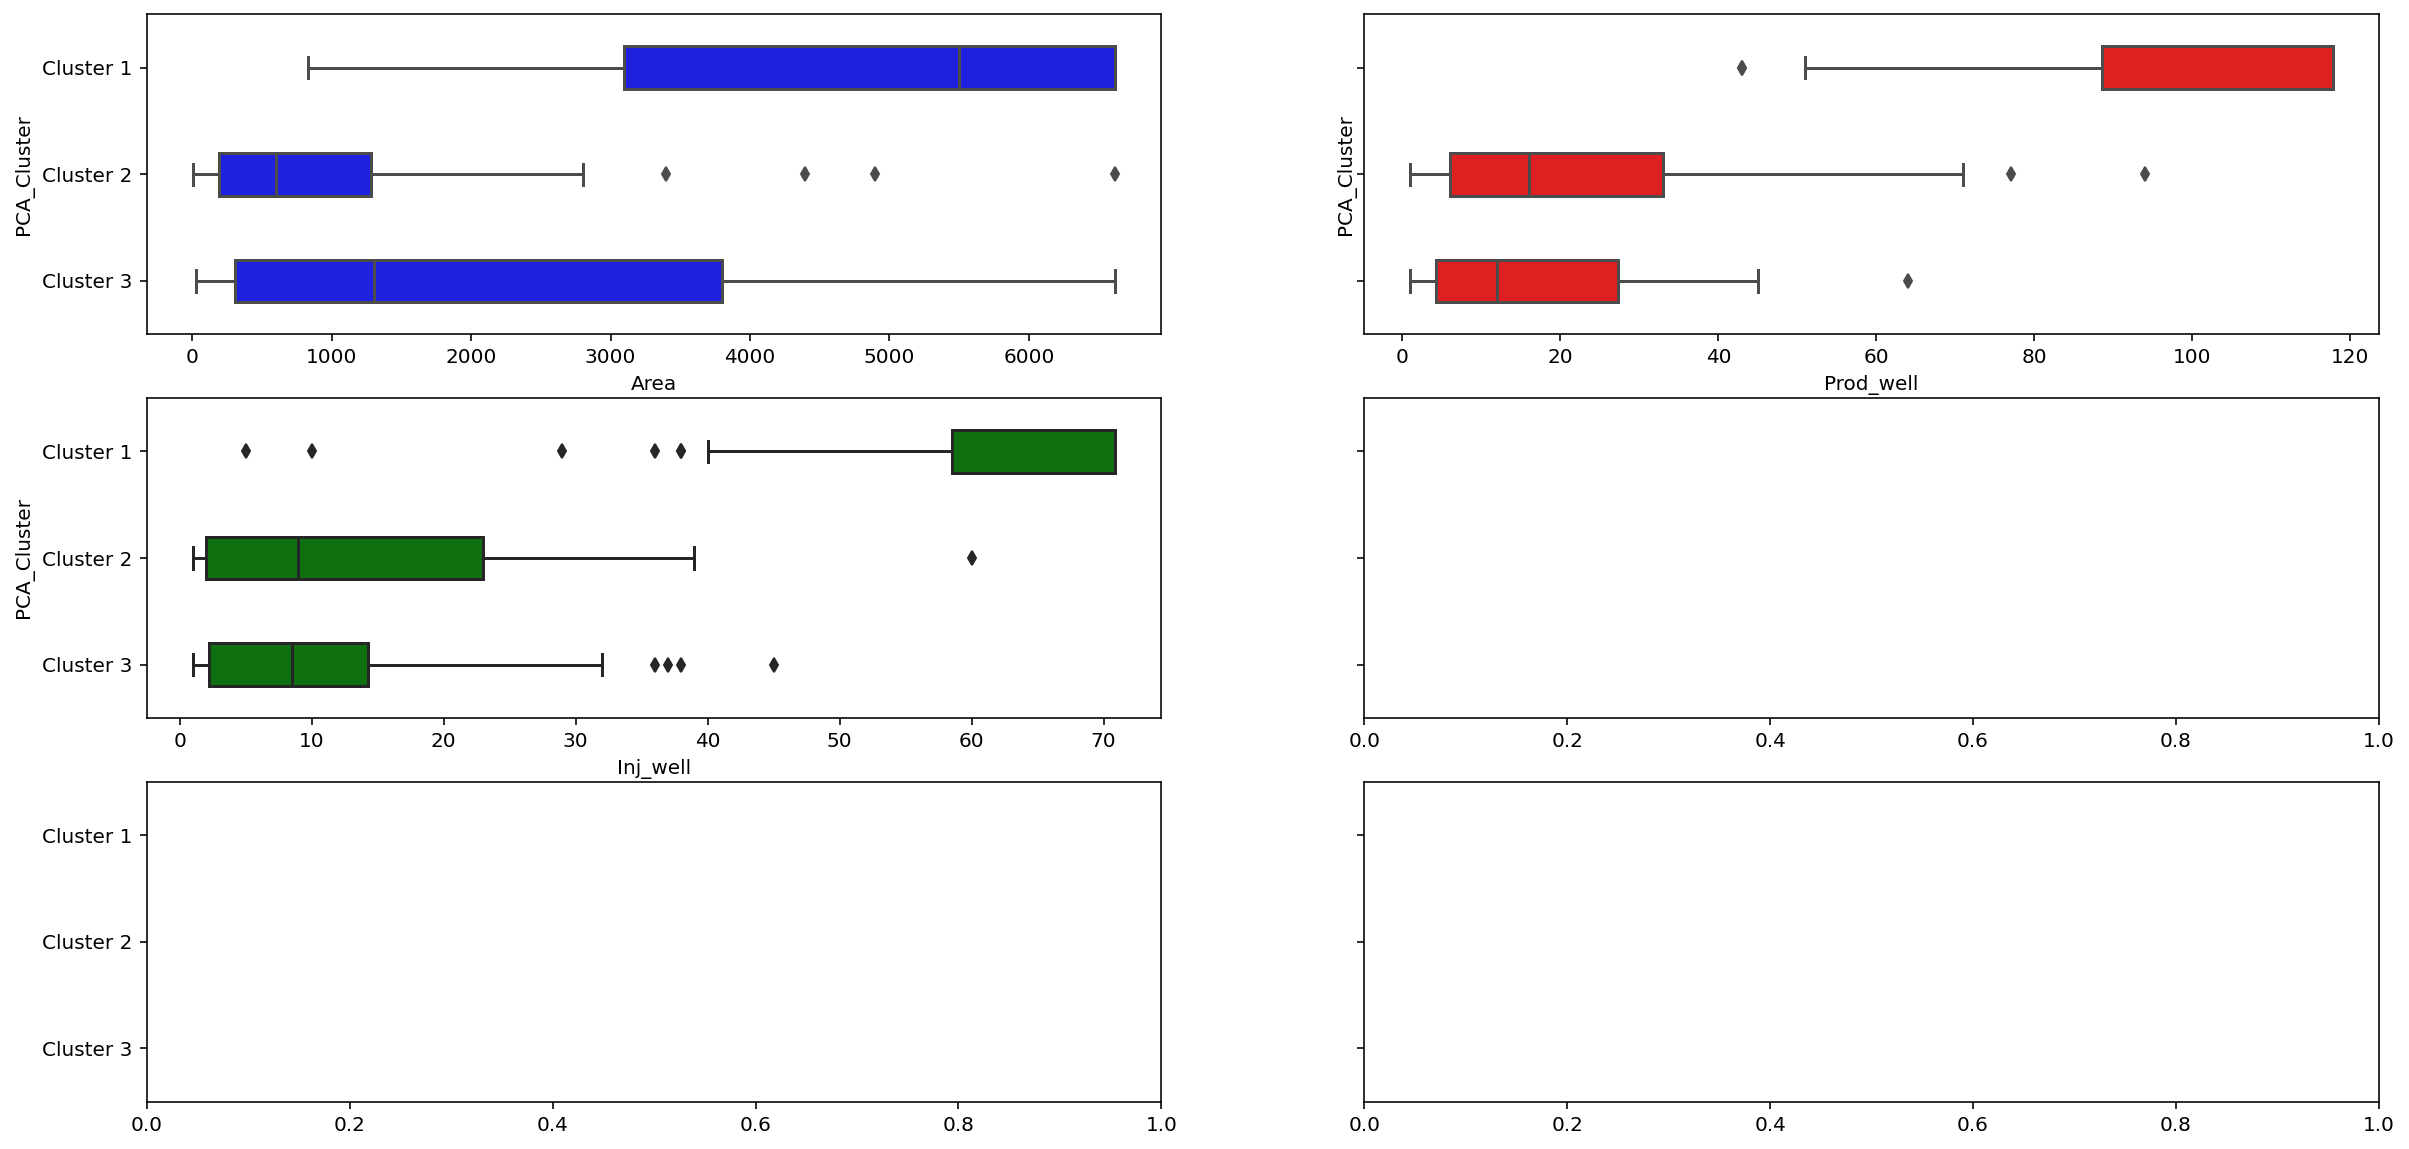

In [57]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10), sharey=True)
width = .4
sns.boxplot(y="PCA_Cluster", x='Area', color="blue", data= df_clus, ax=axes[0, 0], width=width,orient='h')
sns.boxplot(y="PCA_Cluster", x='Prod_well', color="red", data= df_clus, ax=axes[0, 1], width=width,orient='h')
sns.boxplot(y="PCA_Cluster", x='Inj_well', color="green", data= df_clus, ax=axes[1, 0], width=width,orient='h')
plt.yticks([0,1, 2], ['Cluster 1', 'Cluster 2', 'Cluster 3'])

## Saving to CSV file

In [64]:
# Create new dataframe from results dataset
new_df = df[['Form','Prev_prod']]

# Concatenate to categorical columns from original dataset
df_save = pd.concat([df_clus.reset_index(drop= True), new_df.reset_index(drop= True)], axis=1)

#Save to CSV File
df_save.to_csv (r'CO2_export_df.csv', index = False, header=True)